# CNN Model Evaluation Notebook

# Import libraries

In [1]:
import os
import zipfile
import platform
import warnings
import time
from glob import glob
from dataclasses import dataclass

# To filter UserWarning.
warnings.filterwarnings("ignore", category=UserWarning)

import cv2
import requests
import numpy as np
import matplotlib.pyplot as plt

# Importing torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# For data augmentation and preprocessing
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Imports required SegFormer classes
from transformers import SegformerForSemanticSegmentation

# Importing lighting along with a built-in callback it provides.
import lightning.pytorch as pl
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint

# Importing torchmetrics modular and functional implementations.
from torchmetrics import MeanMetric
from torchmetrics.classification import MulticlassF1Score
from torch.utils.data import Dataset, DataLoader

# To print model summary.
#from torchinfo import summary

# Tensor and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

C:\Users\ssre_\.venv_common\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Sets the internal precision of float32 matrix multiplications.
torch.set_float32_matmul_precision('high')

# To enable determinism.
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

# To render the matplotlib figure in the notebook.
%matplotlib inline

In [3]:
ROOT_PATH = "2d_all_v2"
MODEL_PATH = "models"
CLASS_MODEL1 = "resnet50v2_nn256_lr0001_relu_batch32_epoch30_v2.keras"
CLASS_MODEL2 = "resnet50v2_nn256_lr0001_relu_batch64_epoch30_v4.keras"
SEG_MODEL_SLC = "ckpt_epoch=049-vloss_val_loss=0.0000_vf1_valid_f1=0.0000.ckpt"
SEG_MODEL_ALL = "With_All_Sections.ckpt"

# Configuration Class Definition

In [4]:
# Define configuration classes

# A class that holds all the hyperparameters we will use to process images.
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES:   int = 4 # including background.
    IMAGE_SIZE: tuple[int,int] = (288, 288) # W, H
    MEAN: tuple = (0.485, 0.456, 0.406)
    STD:  tuple = (0.229, 0.224, 0.225)
    MEAN_CLF: float = 0.136
    STD_CLF: float = 0.178
    BACKGROUND_CLS_ID: int = 0
    URL: str = r"https://www.dropbox.com/scl/fi/r0685arupp33sy31qhros/dataset_UWM_GI_Tract_train_valid.zip?rlkey=w4ga9ysfiuz8vqbbywk0rdnjw&dl=1"
    DATASET_PATH: str = os.path.join(os.getcwd(), ROOT_PATH)
    MODEL_NAME_CLF1 = os.path.join(MODEL_PATH, CLASS_MODEL1)
    MODEL_NAME_CLF2 = os.path.join(MODEL_PATH, CLASS_MODEL2)
    MODEL_NAME_SEG_SLC = os.path.join(MODEL_PATH, SEG_MODEL_SLC)
    MODEL_NAME_SEG_ALL = os.path.join(MODEL_PATH, SEG_MODEL_ALL)
    THR1: float = 0.019938506186008453
    THR2: float = 0.07652711868286133

# A class containing the locations of the images and masks of these model evaluation tests
@dataclass(frozen=True)
class Paths:
    DATA_VALID_IMAGES: str = os.path.join(DatasetConfig.DATASET_PATH, "valid", "images", r"*.png")
    DATA_VALID_LABELS: str = os.path.join(DatasetConfig.DATASET_PATH, "valid", "masks",  r"*.png")

# A class that holds all the hyperparameters for training and evaluation.
@dataclass
class TrainingConfig:
    BATCH_SIZE:      int = 12 # 8
    NUM_EPOCHS:      int = 1
    INIT_LR:       float = 3e-4
    NUM_WORKERS:     int = 0 if platform.system() == "Windows" else os.cpu_count()

    OPTIMIZER_NAME:  str = "AdamW"
    WEIGHT_DECAY:  float = 1e-4
    USE_SCHEDULER:  bool = True # Use learning rate scheduler?
    SCHEDULER:       str = "MultiStepLR" # Name of the scheduler to use.
    MODEL_NAME:str = "nvidia/segformer-b4-finetuned-ade-512-512"

# A class that contains the (optional) batch size and the number of batches to be used to display for inference results.
#@dataclass
class InferenceConfig:
    BATCH_SIZE:  int = 10
    NUM_BATCHES: int = 2

DatasetConfig.NUM_CLASSES = 4

# Class Definition

In [5]:
# Custom Class MedicalDataset for creating training and validation (segmentation) dataset objects.

# Class inherited from Pytorch Dataset
class MedicalDataset(Dataset):
    # Initialization function
    def __init__(self, *, image_paths, mask_paths, img_size, ds_mean, ds_std, ds_mean_clf, ds_std_clf):
        self.image_paths = image_paths
        self.mask_paths  = mask_paths
        self.img_size    = img_size
        self.ds_mean = ds_mean
        self.ds_std = ds_std
        self.ds_mean_clf = ds_mean_clf
        self.ds_std_clf = ds_std_clf
        self.transforms  = self.setup_transforms(mean=self.ds_mean, std=self.ds_std)

    # Calculates the number of images used for training or validation
    def __len__(self):
        return len(self.image_paths)

    # Normalization Function for binary classification (stomach/small/large bowel: yes, no)
    def normalize_classif(self, image):
        image = image / 255.0
        image = (image - self.ds_mean_clf) / self.ds_std_clf
        return image

    # Preprocess transforms - Normalization and converting to PyTorch tensor format (HWC --> CHW).
    def setup_transforms(self, *, mean, std):
        transforms = []        
        transforms.extend([
                A.Normalize(mean=mean, std=std, always_apply=True),
                ToTensorV2(always_apply=True),  # (H, W, C) --> (C, H, W)
        ])
        return A.Compose(transforms)

    # load and resize the image to the specified size.
    # The interpolation method used is nearest-neighbor for the segmentation model.
    def load_file_nearest(self, file_path, depth=0):
        file = cv2.imread(file_path, depth)
        if depth == cv2.IMREAD_COLOR:
            file = file[:, :, ::-1]
        return cv2.resize(file, (self.img_size), interpolation=cv2.INTER_NEAREST)

    # load and resize the image to the specified size.
    # The interpolation method used is linear for the classification model.
    def load_file_linear(self, file_path, depth=0):
        file = cv2.imread(file_path, depth)
        if depth == cv2.IMREAD_COLOR:
            file = file[:, :, ::-1]
        return cv2.resize(file, (self.img_size), interpolation=cv2.INTER_LINEAR)

    def __getitem__(self, index):
        # Load and preprocess image for classification
        image_clf = self.load_file_linear(self.image_paths[index], depth=cv2.IMREAD_COLOR)
        image_clf = self.normalize_classif(image_clf)
        
        # Load and preprocess image and mask file, both for segmentation
        image = self.load_file_nearest(self.image_paths[index], depth=cv2.IMREAD_COLOR)       
        mask  = self.load_file_nearest(self.mask_paths[index],  depth=cv2.IMREAD_GRAYSCALE)        
        transformed = self.transforms(image=image, mask=mask)

        # Return the loeaded images
        image, mask = transformed["image"], transformed["mask"].to(torch.long)        
        return image_clf, image, mask

In [6]:
# Class MedicalSegmentationDataModule helps organize and encapsulate all the data-related operations and logic
# in a PyTorch project. It acts as a bridge between your data and Lightning’s training pipeline. It is a convenient
# abstraction that encapsulates data-related operations, promotes code organization, and facilitates seamless integration
# with other Lightning components for efficient and reproducible deep-learning experiments.

#LightningDataModule: a datamodule that encapsulates the five steps involved in data processing in PyTorch: Download / tokenize / process; 
# Clean and (maybe) save to disk; Load inside Dataset; Apply transforms (rotate, tokenize, etc…); Wrap inside a DataLoader.

class MedicalSegmentationDataModule(pl.LightningDataModule):
    def __init__(
        self,
        num_classes=10,
        img_size=(384, 384),
        ds_mean=(0.485, 0.456, 0.406),
        ds_std=(0.229, 0.224, 0.225),
        ds_mean_clf=0.136,
        ds_std_clf=0.178,
        batch_size=12,
        num_workers=3,
        pin_memory=False,
        shuffle_validation=False,
    ):
        super().__init__()

        self.num_classes = num_classes
        self.img_size    = img_size
        self.ds_mean     = ds_mean
        self.ds_std      = ds_std
        self.ds_mean_clf = ds_mean_clf
        self.ds_std_clf  = ds_std_clf
        self.batch_size  = batch_size
        self.num_workers = num_workers
        self.pin_memory  = pin_memory
        self.shuffle_validation = shuffle_validation

    # Create validation dataset and dataloader.
    def setup(self, *args, **kwargs):        
        valid_imgs = sorted(glob(f"{Paths.DATA_VALID_IMAGES}"))        
        valid_msks = sorted(glob(f"{Paths.DATA_VALID_LABELS}"))
        self.valid_ds = MedicalDataset(image_paths=valid_imgs, mask_paths=valid_msks, img_size=self.img_size, 
                                       ds_mean=self.ds_mean, ds_std=self.ds_std,
                                       ds_mean_clf=self.ds_mean_clf, ds_std_clf=self.ds_std_clf)

    # Create validation dataloader object.
    def val_dataloader(self):        
        return DataLoader(
            self.valid_ds, batch_size=self.batch_size,  pin_memory=self.pin_memory,
            num_workers=self.num_workers, shuffle=self.shuffle_validation
        )

In [7]:
# Loading a pre-trained model version
def get_model(*, model_name, num_classes):
    model = SegformerForSemanticSegmentation.from_pretrained(
        model_name,
        num_labels=num_classes,
        ignore_mismatched_sizes=True,
    )
    return model
    
class MedicalSegmentationModel(pl.LightningModule):
    def __init__(
        self,
        model_name: str,
        num_classes: int = 10,
        init_lr: float = 0.001,
        optimizer_name: str = "Adam",
        weight_decay: float = 1e-4,
        use_scheduler: bool = False,
        scheduler_name: str = "multistep_lr",
        num_epochs: int = 1,
    ):
        super().__init__()

        # Save the arguments as hyperparameters.
        self.save_hyperparameters()

        # Loading model using the function defined above.
        self.model = get_model(model_name=self.hparams.model_name, num_classes=self.hparams.num_classes)

        # Initializing the required metric objects.
        self.mean_train_loss = MeanMetric()
        self.mean_train_f1 = MulticlassF1Score(num_classes=self.hparams.num_classes, average="macro")
        self.mean_valid_loss = MeanMetric()
        self.mean_valid_f1 = MulticlassF1Score(num_classes=self.hparams.num_classes, average="macro")

    def forward(self, data):
        outputs = self.model(pixel_values=data, return_dict=True)
        upsampled_logits = F.interpolate(outputs["logits"], size=data.shape[-2:], mode="bilinear", align_corners=False)
        return upsampled_logits

# Evaluation Functions

In [8]:
# Compute Dice coefficient
def dice_coeff(predictions, ground_truths, num_classes=4, dims=(1, 2), smooth=1e-8):
    # (batch_size, height, width, num_classes)
    ground_truth_oh = F.one_hot(ground_truths, num_classes=num_classes)
    # (batch_size, height, width, num_classes)
    prediction_norm = F.one_hot(predictions, num_classes=num_classes)
    # (batch_size, num_classes)
    intersection = (prediction_norm * ground_truth_oh).sum(dim=dims)
    # (batch_size, num_classes)
    summation = prediction_norm.sum(dim=dims) + ground_truth_oh.sum(dim=dims)
    # (batch_size, num_classes)
    dice = (2.0 * intersection + smooth) / (summation + smooth)
    # Compute averages: overall and per class
    dice_mean = dice.mean()
    dice_mean_per_class = dice.mean(dim=0)
    return np.concatenate([np.array([dice_mean]), dice_mean_per_class])

# Detect if the mask includes any of the classes
def detect_nonzero_masks(masks):
    # Check if any element is nonzero along the last two axes
    nonzero_masks_mask = np.any(masks != 0, axis=(1, 2))
    # Get the indices of the zero images
    nonzero_masks_indices = np.where(nonzero_masks_mask)[0]
    return nonzero_masks_indices

In [9]:
# Function that performs the evaluation process of the model
@torch.inference_mode()
def inference(class_model, seg_model, loader, img_size, device="cpu", enable_clf=False, threshold_clf=0):
    
    cont = 0
    cont_2 = 0
    score_sum = 0
    score_sum_2 = 0
    score_sum_per_class = np.zeros(4)
    score_sum_per_class_2 = np.zeros(4)
    score = 1.0
    score_2 = 1.0
    score_ave = 1.0
    score_ave_2 = 1.0
    score_ave_per_class = np.ones(4)
    score_ave_per_class_2 = np.ones(4)
    time_sum = 0

    for idx, (batch_img_clf, batch_img_seg, batch_mask) in enumerate(loader):

        batch_size = batch_mask.shape[0]
        start = time.perf_counter()

        if enable_clf: # Classification -> Segmentation
        
            # Classification predictions
            y_pred_clf = class_model.predict(batch_img_clf, verbose=0).reshape(-1)
            clf_labels = y_pred_clf > threshold_clf
            true_idxs = np.where(clf_labels == True)[0]
            
            # Segmentation predictions            
            pred_all = torch.Tensor(np.zeros(batch_mask.shape)).long()
            if len(true_idxs) > 0:
                predictions = seg_model(batch_img_seg[true_idxs].to(device))
                pred_all[true_idxs] = torch.from_numpy(predictions.argmax(dim=1).cpu().numpy())
                pred_all = torch.tensor(pred_all)
                
        else: # Segmentation only
            
            # Segmentation predictions
            predictions = seg_model(batch_img_seg.to(device))
            pred_all = predictions.argmax(dim=1).cpu().numpy()
            pred_all = torch.tensor(pred_all)

        # Compute modeling time
        end = time.perf_counter()
        time_sum = time_sum + ((end - start) / batch_size)

        # Compute Dice coefficient
        cont = cont + 1
        score = dice_coeff(pred_all, batch_mask)
        score_sum = score_sum + score[0]        
        score_sum_per_class = score_sum_per_class + score[1:]        
        
        nonzero_mask_idxs = detect_nonzero_masks(batch_mask.numpy())
        
        if len(nonzero_mask_idxs) > 0:
            cont_2 = cont_2 + 1
            score_2 = dice_coeff(pred_all[nonzero_mask_idxs],batch_mask[nonzero_mask_idxs])
            score_sum_2 = score_sum_2 + score_2[0]            
            score_sum_per_class_2 = score_sum_per_class_2 + score_2[1:]            

        #if idx == InferenceConfig.NUM_BATCHES * 2:
        #    break

    score_ave = score_sum / cont
    score_ave_2 = score_sum_2 / cont_2
    score_ave_per_class = score_sum_per_class / cont
    score_ave_per_class_2 = score_sum_per_class_2 / cont_2
    time_per_image = time_sum / cont

    return score_ave, score_ave_2, score_ave_per_class, score_ave_per_class_2, time_per_image

In [10]:
# Report function
def print_report(score_ave_per_class, score_ave_per_class_2, time_per_image, decimals=5):
    print("-----" * 7)
    print(f"ave dice_score (all masks): {np.round(np.mean(score_ave_per_class[1:]),decimals)}")
    print(f"ave dice_score (only segmented): {np.round(np.mean(score_ave_per_class_2[1:]),decimals)}") 
    print(f"ave dice_score per class (all masks): {np.round(score_ave_per_class,decimals)}")
    print(f"ave dice_score per class (only segmented): {np.round(score_ave_per_class_2,decimals)}") 
    print(f"seconds per image: {np.round(time_per_image,decimals)}")
    print(f"images per second: {np.round(1 / time_per_image,decimals)}")

# Model Evaluation

## Load models

In [11]:
# Seed everything for reproducibility.
pl.seed_everything(42, workers=True)

# Get the validation dataloader.
data_module = MedicalSegmentationDataModule(
    num_classes=DatasetConfig.NUM_CLASSES,
    img_size=DatasetConfig.IMAGE_SIZE,
    ds_mean=DatasetConfig.MEAN,
    ds_std=DatasetConfig.STD,
    ds_mean_clf=DatasetConfig.MEAN_CLF,
    ds_std_clf=DatasetConfig.STD_CLF,
    batch_size=InferenceConfig.BATCH_SIZE,
    num_workers=TrainingConfig.NUM_WORKERS,
    pin_memory=torch.cuda.is_available(),
)

data_module.setup()
valid_loader = data_module.val_dataloader()

Seed set to 42


In [12]:
# Load classification model
class_model_1 = load_model(DatasetConfig.MODEL_NAME_CLF1)
class_model_2 = load_model(DatasetConfig.MODEL_NAME_CLF2)

In [13]:
# Load segmentation model (SegFormer 1)
seg_model_1 = MedicalSegmentationModel.load_from_checkpoint(DatasetConfig.MODEL_NAME_SEG_SLC)
seg_model_2 = MedicalSegmentationModel.load_from_checkpoint(DatasetConfig.MODEL_NAME_SEG_ALL)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b4-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([4, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b4-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([4, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in 

## SegFormer 1 (Trained With Only Segmented Slices)

In [14]:
# Use GPU if available.
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
seg_model_1.to(DEVICE)

_, _, score_ave_per_class_1, score_ave_per_class_2_1, time_per_image_1 = inference(class_model_1, seg_model_1, valid_loader, device=DEVICE, img_size=DatasetConfig.IMAGE_SIZE, enable_clf=False, threshold_clf=0)

print_report(score_ave_per_class_1, score_ave_per_class_2_1, time_per_image_1)

-----------------------------------
ave dice_score (all masks): 0.72529
ave dice_score (only segmented): 0.94141
ave dice_score per class (all masks): [0.99437 0.68318 0.74076 0.75192]
ave dice_score per class (only segmented): [0.9973  0.95939 0.9302  0.93464]
seconds per image: 0.20985
images per second: 4.76533


## Classifier 1 + SegFormer 1

In [15]:
# Use GPU if available.
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
seg_model_1.to(DEVICE)

_, _, score_ave_per_class_11, score_ave_per_class_2_11, time_per_image_11 = inference(class_model_1, seg_model_1, valid_loader, device=DEVICE, img_size=DatasetConfig.IMAGE_SIZE, enable_clf=True, threshold_clf=DatasetConfig.THR1)

print_report(score_ave_per_class_11, score_ave_per_class_2_11, time_per_image_11)

-----------------------------------
ave dice_score (all masks): 0.9244
ave dice_score (only segmented): 0.93495
ave dice_score per class (all masks): [0.99737 0.95261 0.90983 0.91076]
ave dice_score per class (only segmented): [0.99719 0.957   0.9219  0.92595]
seconds per image: 0.14841
images per second: 6.73801


## Classifier 2 + SegFormer 1

In [16]:
# Use GPU if available.
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
seg_model_1.to(DEVICE)

_, _, score_ave_per_class_21, score_ave_per_class_2_21, time_per_image_21 = inference(class_model_2, seg_model_1, valid_loader, device=DEVICE, img_size=DatasetConfig.IMAGE_SIZE, enable_clf=True, threshold_clf=DatasetConfig.THR2)

print_report(score_ave_per_class_21, score_ave_per_class_2_21, time_per_image_21)

-----------------------------------
ave dice_score (all masks): 0.92425
ave dice_score (only segmented): 0.93526
ave dice_score per class (all masks): [0.99738 0.95018 0.91079 0.9118 ]
ave dice_score per class (only segmented): [0.99718 0.9567  0.92263 0.92646]
seconds per image: 0.14696
images per second: 6.80477


## SegFormer 2 (Trained With All Slices)

In [17]:
# Use GPU if available.
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
seg_model_2.to(DEVICE)

_, _, score_ave_per_class_2, score_ave_per_class_2_2, time_per_image_2 = inference(class_model_1, seg_model_2, valid_loader, device=DEVICE, img_size=DatasetConfig.IMAGE_SIZE, enable_clf=False, threshold_clf=0)

print_report(score_ave_per_class_2, score_ave_per_class_2_2, time_per_image_2)

-----------------------------------
ave dice_score (all masks): 0.62771
ave dice_score (only segmented): 0.85549
ave dice_score per class (all masks): [0.99305 0.59435 0.65299 0.63578]
ave dice_score per class (only segmented): [0.99549 0.90385 0.80621 0.85642]
seconds per image: 0.20974
images per second: 4.7678


## Classifier 1 + Segformer2

In [18]:
# Use GPU if available.
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
seg_model_2.to(DEVICE)

_, _, score_ave_per_class_12, score_ave_per_class_2_12, time_per_image_12 = inference(class_model_1, seg_model_2, valid_loader, device=DEVICE, img_size=DatasetConfig.IMAGE_SIZE, enable_clf=True, threshold_clf=DatasetConfig.THR1)

print_report(score_ave_per_class_12, score_ave_per_class_2_12, time_per_image_12)

-----------------------------------
ave dice_score (all masks): 0.88519
ave dice_score (only segmented): 0.85158
ave dice_score per class (all masks): [0.99655 0.92951 0.85249 0.87358]
ave dice_score per class (only segmented): [0.99541 0.90364 0.80031 0.85081]
seconds per image: 0.14487
images per second: 6.90255


## Classifier 2 + Segformer2

In [19]:
# Use GPU if available.
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
seg_model_2.to(DEVICE)

_, _, score_ave_per_class_22, score_ave_per_class_2_22, time_per_image_22 = inference(class_model_2, seg_model_2, valid_loader, device=DEVICE, img_size=DatasetConfig.IMAGE_SIZE, enable_clf=True, threshold_clf=DatasetConfig.THR2)

print_report(score_ave_per_class_22, score_ave_per_class_2_22, time_per_image_22)

-----------------------------------
ave dice_score (all masks): 0.88574
ave dice_score (only segmented): 0.85172
ave dice_score per class (all masks): [0.99657 0.928   0.85383 0.87539]
ave dice_score per class (only segmented): [0.99541 0.90333 0.80089 0.85093]
seconds per image: 0.14538
images per second: 6.8785


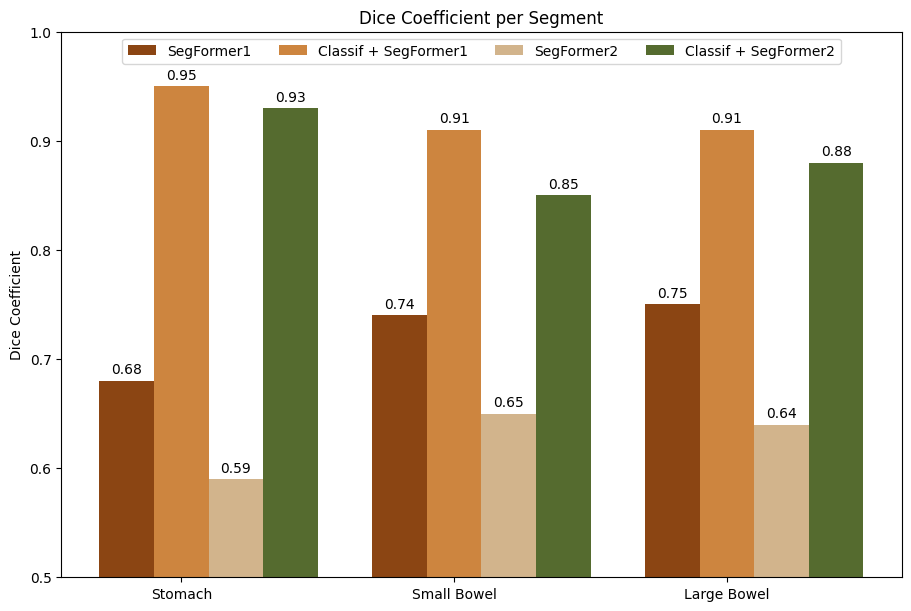

In [20]:
organs = ("Stomach", "Small Bowel", "Large Bowel")
method = {
    'SegFormer1': (score_ave_per_class_1[1], score_ave_per_class_1[2], score_ave_per_class_1[3]),
    'Classif + SegFormer1': (score_ave_per_class_21[1], score_ave_per_class_21[2], score_ave_per_class_21[3]),
    'SegFormer2': (score_ave_per_class_2[1], score_ave_per_class_2[2], score_ave_per_class_2[3]),
    'Classif + SegFormer2': (score_ave_per_class_22[1], score_ave_per_class_22[2], score_ave_per_class_22[3]) 
}

x = np.arange(len(organs))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

# Custom color palette
colors = ['#8B4513', '#CD853F', '#D2B48C', '#556B2F']  # Add more colors if needed

fig, ax = plt.subplots(layout='constrained', figsize=[9,6])

for attribute, measurement, color in zip(method.keys(), method.values(), colors):
    offset = width * multiplier
    rects = ax.bar(x + offset, np.round(measurement,2), width, label=attribute, color=color)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Dice Coefficient')
ax.set_title('Dice Coefficient per Segment')
ax.set_xticks(x + width, organs)
ax.legend(loc='upper center', ncol=4)
ax.set_ylim(0.5, 1)
plt.savefig('images/dice_coeff.png')
plt.show()

In [87]:
#%store -r score_ave_per_class_1 score_ave_per_class_2_1 time_per_image_1 score_ave_per_class_2 score_ave_per_class_2_2 time_per_image_2 score_ave_per_class_11 score_ave_per_class_2_11 time_per_image_11 score_ave_per_class_21 score_ave_per_class_2_21 time_per_image_21 score_ave_per_class_22 score_ave_per_class_2_22 time_per_image_22
#model_evaluation_variables

In [21]:
import pickle

# Variables to save
variables_to_save = {
    "score_ave_per_class_1": score_ave_per_class_1,
    "score_ave_per_class_2_1": score_ave_per_class_2_1,
    "time_per_image_1": time_per_image_1,
    "score_ave_per_class_2": score_ave_per_class_2,
    "score_ave_per_class_2_2": score_ave_per_class_2_2,
    "time_per_image_2": time_per_image_2,
    "score_ave_per_class_11": score_ave_per_class_11,
    "score_ave_per_class_2_11": score_ave_per_class_2_11,
    "time_per_image_11": time_per_image_11,
    "score_ave_per_class_21": score_ave_per_class_21,
    "score_ave_per_class_2_21": score_ave_per_class_2_21,
    "time_per_image_21": time_per_image_21,
    "score_ave_per_class_22": score_ave_per_class_22,
    "score_ave_per_class_2_22": score_ave_per_class_2_22,
    "time_per_image_22": time_per_image_22,
}

# Specify the file path
file_path = 'models/model_evaluation_variables.pkl'

# Save variables to a file
with open(file_path, 'wb') as f:
    pickle.dump(variables_to_save, f)

In [22]:

# Specify the file path
file_path = 'models/model_evaluation_variables.pkl'

# Load variables from the file
with open(file_path, 'rb') as f:
    loaded_variables = pickle.load(f)

# Access the loaded variables
score_ave_per_class_1_ = loaded_variables["score_ave_per_class_1"]
score_ave_per_class_2_1_ = loaded_variables["score_ave_per_class_2_1"]
time_per_image_1_ = loaded_variables["time_per_image_1"]
score_ave_per_class_2_ = loaded_variables["score_ave_per_class_2"]
score_ave_per_class_2_2_ = loaded_variables["score_ave_per_class_2_2"]
time_per_image_2_ = loaded_variables["time_per_image_2"]
score_ave_per_class_11_ = loaded_variables["score_ave_per_class_11"]
score_ave_per_class_2_11_ = loaded_variables["score_ave_per_class_2_11"]
time_per_image_11_ = loaded_variables["time_per_image_11"]
score_ave_per_class_21_ = loaded_variables["score_ave_per_class_21"]
score_ave_per_class_2_21_ = loaded_variables["score_ave_per_class_2_21"]
time_per_image_21_ = loaded_variables["time_per_image_21"]
score_ave_per_class_22_ = loaded_variables["score_ave_per_class_22"]
score_ave_per_class_2_22_ = loaded_variables["score_ave_per_class_2_22"]
time_per_image_22_ = loaded_variables["time_per_image_22"]